# CLUSTER SEMANAL

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns; sns.set()

In [3]:
from datetime import datetime
def fechas(x):
    x = datetime.strptime(x, '%m-%d-%Y %I:%M %p')
    return x

In [4]:
patient_0_RN = pd.read_csv('patient0.csv')
patient_0_RN.dropna(inplace = True)
patient_0_RN.reset_index(drop=True, inplace=True)
patient_0_RN.head()

patient_0_RN['DATES'] = patient_0_RN['DATE'].apply(fechas)
patient_0_RN.drop('DATE', axis = 1, inplace = True)
patient_0_RN.head()

patient_0_RN.rename(columns={' LEVEL':'LEVEL'}, inplace=True)

patient_0_RN.sort_values('DATES', ascending=True, inplace=True)
patient_0_RN.drop_duplicates(inplace=True)
patient_0_RN.head()

,LEVEL,DATES
85599,194.0,2016-08-24 15:20:00
85600,164.0,2016-08-24 15:35:00
85601,126.0,2016-08-24 15:50:00
85602,87.0,2016-08-24 16:05:00
85603,65.0,2016-08-24 16:20:00


In [5]:
import datetime

In [6]:
split_date = datetime.datetime(year=2018, month=8, day=1)
df_train  = patient_0_RN.loc[patient_0_RN['DATES']<split_date]
df_test = patient_0_RN.loc[patient_0_RN['DATES']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)

Shape of train: (57751, 2)
Shape of test: (18363, 2)


In [7]:
df_train.sort_values('DATES', ascending=True, inplace=True)
df_test.sort_values('DATES', ascending=True, inplace=True)

#Reset the indices of the validation set
df_test.reset_index(drop=True, inplace=True)

#Reset the indices of the train set
df_train.reset_index(drop=True, inplace=True)

c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# Vemos que la mayoría de los días tienen 88 o mas mediciones
df_train.loc[:,"week"] = df_train.DATES.dt.floor("7d")
df_train.groupby("week").size().value_counts()

c:\users\jbart\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jbart\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


669    6
662    6
663    5
667    5
654    4
659    4
666    4
671    3
660    3
651    3
668    3
658    3
652    2
655    2
656    2
657    2
661    2
644    2
664    2
642    2
542    1
613    1
123    1
645    1
647    1
648    1
534    1
650    1
628    1
627    1
653    1
621    1
230    1
525    1
672    1
606    1
604    1
710    1
577    1
440    1
310    1
558    1
665    1
35     1
638    1
673    1
639    1
dtype: int64

In [9]:
df_test.loc[:,"week"] = df_test.DATES.dt.floor("7d")
df_test.groupby("week").size().value_counts()

667    3
661    3
664    2
663    2
660    2
656    2
671    1
621    1
675    1
623    1
646    1
648    1
548    1
658    1
626    1
657    1
666    1
659    1
665    1
634    1
96     1
dtype: int64

In [10]:
# 565 superan el punto de corte
cutoff = 600
(df_train.groupby("week").size() >= cutoff).sum() 

82

In [11]:
# 182 superan el punto de corte
cutoff = 600
(df_test.groupby("week").size() >= cutoff).sum()  

27

In [12]:
# de un total de 622 dias
# Es suficientemente grande, perdemos un 20% aprox
df_train.week.nunique()

92

In [13]:
df_test.week.nunique()

29

In [14]:
dias_buenos = (df_train.groupby("week").size() >= cutoff).reset_index(name="ok").query("ok").week
df_train = df_train.loc[df_train.week.isin(dias_buenos),:].reset_index(drop=True)

In [15]:
dias_buenos2 = (df_test.groupby("week").size() >= cutoff).reset_index(name="ok").query("ok").week
df_test = df_test.loc[df_test.week.isin(dias_buenos2),:].reset_index(drop=True)

In [16]:
# Hacemos una muestra cada 15 min para alinear todas las series temporales
df_train_day_series = df_train.set_index(df_train.DATES).LEVEL.resample("15Min").mean()

df_train_day_series = pd.DataFrame({"level":df_train_day_series}).reset_index()

df_train_day_series.loc[:,"week"] = df_train_day_series.DATES.dt.floor("7d")
df_train_day_series.loc[:,"offset"] =df_train_day_series.DATES - df_train_day_series.week

In [17]:
# Hacemos una muestra cada 15 min para alinear todas las series temporales
df_test_day_series = df_test.set_index(df_test.DATES).LEVEL.resample("15Min").mean()

df_test_day_series = pd.DataFrame({"level":df_test_day_series}).reset_index()

df_test_day_series.loc[:,"week"] = df_test_day_series.DATES.dt.floor("7d")
df_test_day_series.loc[:,"offset"] =df_test_day_series.DATES - df_test_day_series.week

In [18]:
df_train_day_series = df_train_day_series.loc[~df_train_day_series.level.isna(),:]

In [19]:
df_test_day_series = df_test_day_series.loc[~df_test_day_series.level.isna(),:]

In [20]:
df_train_day_pivoted = df_train_day_series.pivot(columns="offset",index="week",values="level")

In [21]:
df_test_day_pivoted = df_test_day_series.pivot(columns="offset",index="week",values="level")

In [22]:
df_train_day_pivoted = df_train_day_pivoted.interpolate(axis=1).fillna(method="ffill",axis=1).fillna(method="bfill",axis=1)

In [23]:
df_test_day_pivoted = df_test_day_pivoted.interpolate(axis=1).fillna(method="ffill",axis=1).fillna(method="bfill",axis=1)

In [24]:
df_train_day_pivoted.shape

(82, 672)

In [25]:
df_test_day_pivoted.shape

(27, 672)

In [26]:
# Cada fila es un dia
# Cada columna es un momento del día. Esto es el "perfil del día" y es lo que hay que clusterizar
df_train_day_pivoted

offset,0 days 00:00:00,0 days 00:15:00,0 days 00:30:00,0 days 00:45:00,0 days 01:00:00,0 days 01:15:00,0 days 01:30:00,0 days 01:45:00,0 days 02:00:00,0 days 02:15:00,...,6 days 21:30:00,6 days 21:45:00,6 days 22:00:00,6 days 22:15:00,6 days 22:30:00,6 days 22:45:00,6 days 23:00:00,6 days 23:15:00,6 days 23:30:00,6 days 23:45:00
week,,,,,,,,,,,,,,,,,,,,,
2016-08-25,191.0,195.0,205.0,209.0,208.0,209.0,213.0,218.0,215.0,209.0,...,220.0,223.0,224.0,235.0,244.0,266.0,291.0,302.0,310.0,314.0
2016-09-01,316.0,317.0,316.0,325.0,323.0,296.0,268.0,251.0,252.0,255.0,...,257.0,257.0,257.0,257.0,257.0,257.0,257.0,257.0,257.0,257.0
2016-09-22,158.0,153.0,146.0,139.0,133.0,127.0,119.0,114.0,121.0,136.0,...,259.0,269.0,272.0,277.0,280.0,286.0,294.0,308.0,307.0,277.0
2016-09-29,246.0,234.0,246.0,246.0,234.0,218.0,205.0,198.0,194.0,185.0,...,170.0,197.0,228.0,242.0,231.0,181.0,120.0,83.0,82.0,105.0
2016-10-06,133.0,166.0,198.0,211.0,223.0,237.0,239.0,249.0,256.0,256.0,...,409.0,428.0,449.0,463.0,444.0,387.0,311.0,252.0,215.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26,142.0,161.0,170.0,178.0,190.0,199.0,196.0,188.0,182.0,180.0,...,194.0,197.0,193.0,189.0,186.0,185.0,193.0,206.0,229.0,269.0
2018-05-03,292.0,272.0,240.0,207.0,171.0,156.0,159.0,165.0,175.0,193.0,...,269.0,294.0,278.0,254.0,241.0,238.0,237.0,233.0,238.0,235.0
2018-05-10,231.0,228.0,227.0,230.0,235.0,230.0,223.0,220.0,220.0,215.0,...,235.0,277.0,278.5,280.0,226.0,165.0,115.0,89.0,86.0,85.0


c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


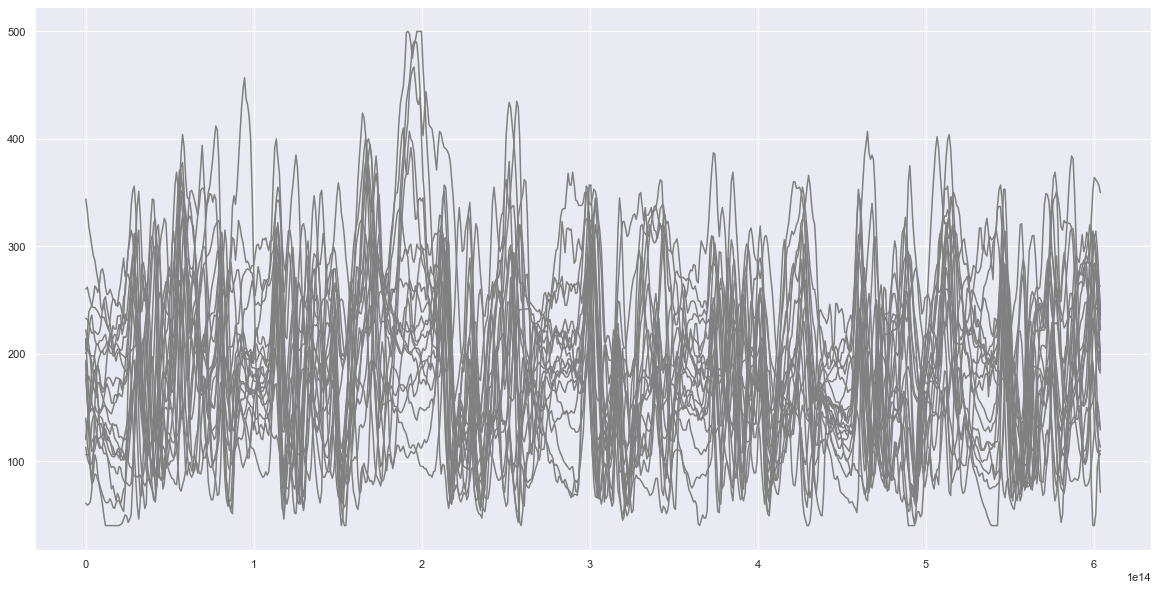

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
fig.show()
for i in range(20,40):
    plt.plot(df_train_day_pivoted.iloc[i,:] , c="grey")
plt.draw()

## Ploteos correctos

In [28]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

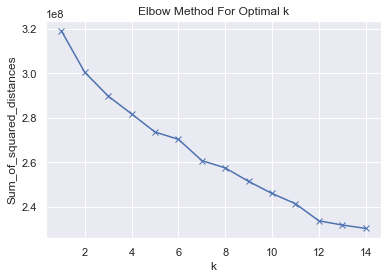

In [29]:
ssd = []
K= range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_train_day_pivoted)
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

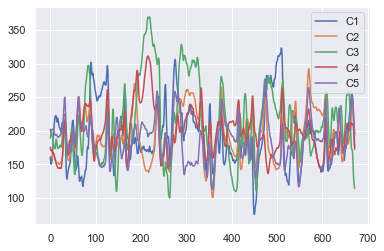

In [30]:
clusters = 5
kmeans = KMeans(n_clusters=clusters).fit(df_train_day_pivoted)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(20,10)) 

for i in range(centroids.shape[0]):
    plt.plot(centroids[i,:], label=f"C{i+1}")
plt.legend()
plt.draw()


In [31]:
def pintar_cluster(df_train_day_pivoted, kmeans, cluster, max_lines=None):
    x_axis = range(df_test_day_pivoted.shape[1])
    fig = plt.figure()
    plt.title(f"Cluster {cluster}")
    cluster_data = df_train_day_pivoted.loc[kmeans.labels_ == cluster,:]
    if max_lines is not None:
        to_plot = cluster_data.sample(frac = 1).iloc[:max_lines,:]        
    else:
        to_plot = cluster_data
    for i in range(to_plot.shape[0]):
        plt.plot(x_axis, to_plot.iloc[i,:], color="grey", alpha=0.2)
    centroid = kmeans.cluster_centers_[cluster,:]
    plt.plot(x_axis, centroid, color="blue")
    plt.draw()

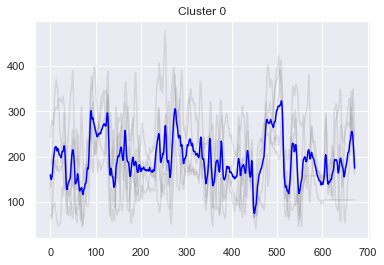

In [32]:
pintar_cluster(df_train_day_pivoted, kmeans, 0, max_lines=30)

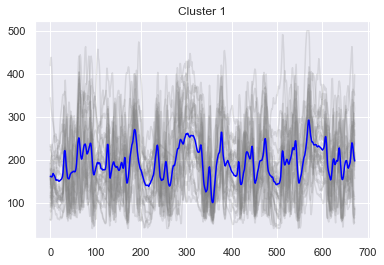

In [33]:
pintar_cluster(df_train_day_pivoted, kmeans, 1, max_lines=30)

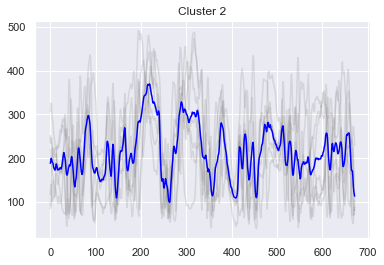

In [34]:
pintar_cluster(df_train_day_pivoted, kmeans, 2, max_lines=30)

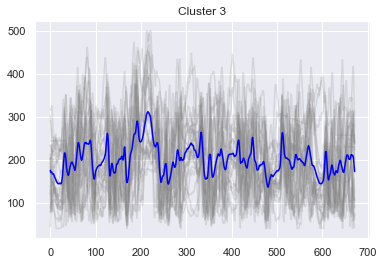

In [35]:
pintar_cluster(df_train_day_pivoted, kmeans, 3, max_lines=30)

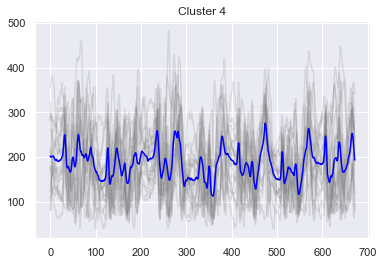

In [36]:
pintar_cluster(df_train_day_pivoted, kmeans, 4, max_lines=30)

# DTW

In [37]:
from tslearn.clustering import TimeSeriesKMeans
import tqdm

c:\users\jbart\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


100%|██████████| 9/9 [56:42<00:00, 378.04s/it]


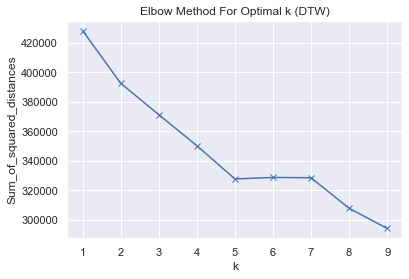

In [38]:
dtw_models = []
ssd = []
K = range(1,10)
for k in tqdm.tqdm(K):
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100, n_jobs=-1)
    km = km.fit(df_train_day_pivoted)
    dtw_models.append(km)
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (DTW)')
plt.show()

In [40]:
def pintar_centroides(model, cluster=None):
    fig = plt.figure()
    ks = range(model.cluster_centers_.shape[0]) if cluster is None else [cluster]
    for i in ks:
        plt.plot(model.cluster_centers_[i].flatten(), label=f"C{i+1}")
    plt.legend()
    plt.draw()
    
# Medimos la distancia al cluster y tomamos el top 15
def pintar_cluster_dtw_closest(df, model, cluster, max_lines=10):
    distancias_a_cluster = np.min(model.transform(df), axis=1)
    labels = model.labels_

    top_closest = np.argsort(distancias_a_cluster[labels == cluster])[:max_lines]
    lines_closest = df_train_day_pivoted.iloc[labels==cluster,:].iloc[top_closest,:]

    x_axis = range(lines_closest.shape[1])
    fig = plt.figure()

    plt.title(f"Cluster {cluster}")
    for i in range(lines_closest.shape[0]):
        plt.plot(x_axis, lines_closest.iloc[i,:], color="grey", alpha=0.2)
    plt.draw()

# Pinta lineas al azar del cluster
def pintar_cluster_dtw(df, model, cluster, max_lines=None):
    x_axis = range(df.shape[1])
    fig = plt.figure()
    plt.title(f"Cluster {cluster}")
    cluster_data = df.loc[model.labels_ == cluster,:]
    if max_lines is not None:
        to_plot = cluster_data.sample(frac = 1).iloc[:max_lines,:]        
    else:
        to_plot = cluster_data
    for i in range(to_plot.shape[0]):
        plt.plot(x_axis, to_plot.iloc[i,:], color="grey", alpha=0.2)
    plt.draw()


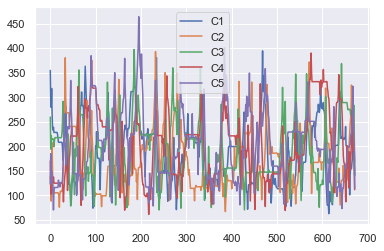

In [41]:
pintar_centroides(dtw_models[4])

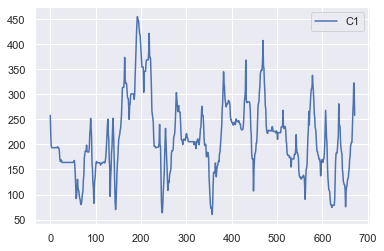

In [42]:
pintar_centroides(dtw_models[5],0)

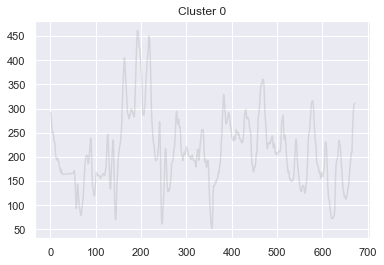

In [43]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 0, max_lines=1)

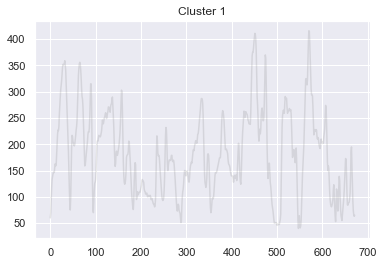

In [44]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 1, max_lines=1)

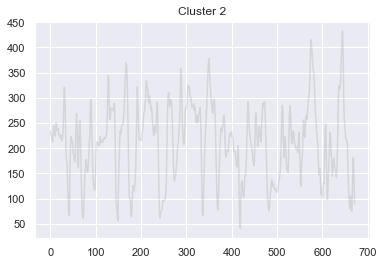

In [45]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 2, max_lines=1)

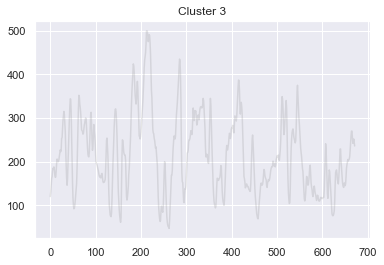

In [46]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 3, max_lines=1)

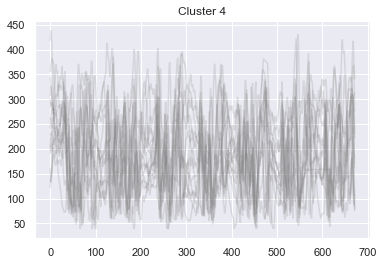

In [47]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 4, max_lines=20)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


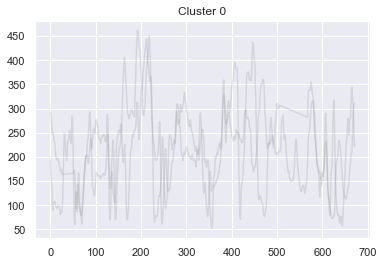

In [49]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=0, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


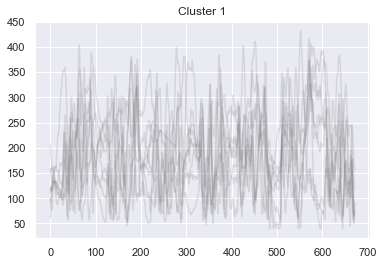

In [50]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=1, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


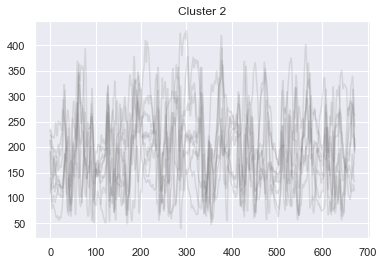

In [51]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=2, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


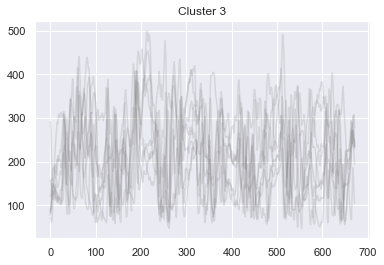

In [52]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=3, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


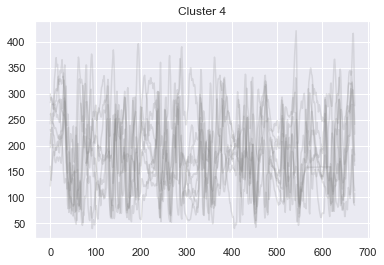

In [53]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=4, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 82 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


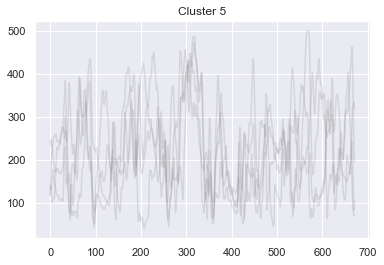

In [54]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=5, max_lines=9)